## Wstęp do uczenia maszynowego 
### Praca domowa 4
#### Jakub Piwko, Malwina Wojewoda
***

### Pakiety

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import sklearn 
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

### Wczytanie i analiza danych

Dane opisują Tajwańskie spółki z lat 1999-2009. Przewidujemy zmienną `Bankrupt?`, która wskazuje, czy dana spółka zbankrutuje. 

In [2]:
df = pd.read_csv('data.csv')

Jak wiemy z poprzedniego zadania domowego, w tym zbiorze nie występują braki danych.

In [3]:
#Wyróżnienie zbioru, na którym będziemy pracować i zbioru do walidacji
y_all = df["Bankrupt?"]
y_all = y_all.astype('int')
X_all = df.drop("Bankrupt?", axis=1)

X, X_val, y, y_val = train_test_split(X_all, y_all, random_state=420, test_size=0.3)

#Wyróżnienie zbioru treningowego i testowego
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
X_train_0 = copy.deepcopy(X_train)

Z racji, że występują duże dyspropocje w licznościach na zmiennej celu, dorobimy sztucznie więcej rekordów za pomocą `SMOTE`.

In [5]:
#sm = SMOTE(random_state=420)
#X_train, y_train = sm.fit_resample(X_train, y_train)

Wykonamy teraz preprocesing z zadanie domowego nr 3 na tych danych:

In [6]:
def preprocessing(df, y):
    
    col_names = df.columns
    indexes_set = set()
    num_of_outliers = []

    for col in col_names:
        tmp_data1 = X_train[col]
        upper_lim1 = tmp_data1.quantile(.975)
        lower_lim1 = tmp_data1.quantile(.025)
        df[col] = np.where(df[col] < upper_lim1, df[col], upper_lim1)
        df[col] = np.where(df[col] > lower_lim1, df[col], lower_lim1)

    cols_to_scale = []
    for col in df.columns:
        if df[col].max() > 1:
            cols_to_scale.append(col)

    for col in cols_to_scale:
        min_max_scaler1 = MinMaxScaler()
        scaled_col1 = min_max_scaler1.fit_transform(df[col].values.reshape(-1, 1))
        df[col] = scaled_col1

    corr = df.corr(method = 'spearman')
    correlated_features = set()

    for i in range(len(corr .columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) >= 0.95:
                colname = corr.columns[i]
                correlated_features.add(colname)
                
    df_y = pd.concat([df, y], axis=1)
    corr = df_y.corr(method = 'spearman')

    columns = df.columns

    for col in columns:
        if corr["Bankrupt?"][col] < 0:
            df[col] *= -1     
        
    return df, y

In [7]:
X_train, y_train = preprocessing(X_train, y_train);

In [8]:
X_test, y_test = preprocessing(X_test, y_test)

## Modele i dobór hiperparametrów 

In [9]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from scipy.stats import poisson,expon

In [10]:
def Scores(model, X, y):
    print(f"Model score: {model.score(X, y)}")
    print(f"Precision score: {precision_score(y, model.predict(X), average='binary')}")
    print(f"Gini score: {roc_auc_score(y, model.predict(X))}")

In [11]:
def print_scores(model):
    print(f"ZBIÓR TRENINGOWY:")
    print(f"Model score: {model.score(X_train, y_train)}")
    print(f"Precision score: {precision_score(y_train, model.predict(X_train), average='binary')}")
    print(f"Gini score: {roc_auc_score(y_train, model.predict(X_train))}")
    print("-------------------------------")
    print(f"ZBIÓR TESTOWY:")
    print(f"Model score: {model.score(X_test, y_test)}")
    print(f"Precision score: {precision_score(y_test, model.predict(X_test), average='binary')}")
    print(f"Gini score: {roc_auc_score(y_test, model.predict(X_test))}")

In [12]:
def show_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plt.show()

### Decision Trees

Na początek wytrenujemy model drzewa decyzyjnego z użyciem domyślnych parametrów. 

In [13]:
tree_base = DecisionTreeClassifier()
tree_base.fit(X_train, y_train)
pred = tree_base.predict(X_test)

In [14]:
print_scores(tree_base)

ZBIÓR TRENINGOWY:
Model score: 1.0
Precision score: 1.0
Gini score: 1.0
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.031424581005586594
Precision score: 0.031424581005586594
Gini score: 0.5


# ZMIENIC
Bazowy model drzewa okazał się już wysoki score, także wyoski gini na zbiorze testowym, jednak patrząc na wyniki zbioru treningowego widać, że jest przetrenowany. Precision score jest niski.

Użyjemy teraz grid search to znalezienia optymalnych parametrów. Do tuningu wybraliśmy parametry `max_depth`, `splitter`, `criterion` i `ccp_alpha`.

In [15]:
max_depth=[3, 4, 5]
splitter = ["best", "random"]
criterion=["gini","entrophy"]
ccp_alpha=[0, 0.05, 0.1]
param_grid = dict(max_depth=max_depth, splitter=splitter, criterion=criterion, ccp_alpha=ccp_alpha)

In [16]:
tree = DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.9652802019279827
Best parameters: {'ccp_alpha': 0.05, 'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'} 


In [17]:
tree1 = DecisionTreeClassifier(ccp_alpha = 0,
                             criterion = 'gini',
                             max_depth = 5,
                             splitter = 'best')
tree1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=5)

In [18]:
print_scores(tree1)

ZBIÓR TRENINGOWY:
Model score: 0.98263992816522
Precision score: 0.881578947368421
Gini score: 0.7873977546110664
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.031424581005586594
Precision score: 0.031424581005586594
Gini score: 0.5


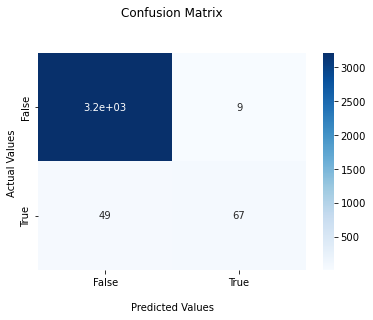

In [19]:
show_confusion_matrix(y_train, tree1.predict(X_train))

Teraz użyjemy Random Search

In [20]:
random = RandomizedSearchCV(estimator=tree, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 420)

random_result = random.fit(X_train, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.9652802019279827
Best parameters: {'splitter': 'best', 'max_depth': 5, 'criterion': 'gini', 'ccp_alpha': 0.05}


In [21]:
tree2 = DecisionTreeClassifier(ccp_alpha = 0,
                             criterion = 'gini',
                             max_depth = 3,
                             splitter = 'random')
tree2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=3, splitter='random')

In [22]:
print_scores(tree2)

ZBIÓR TRENINGOWY:
Model score: 0.9676743489973062
Precision score: 0.75
Gini score: 0.5511039828922748
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.031424581005586594
Precision score: 0.031424581005586594
Gini score: 0.5


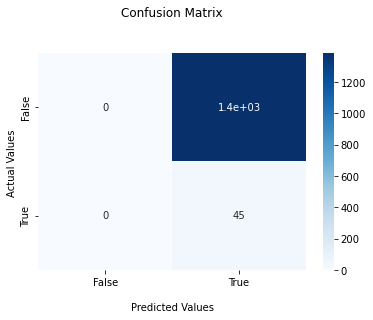

In [23]:
show_confusion_matrix(y_test, tree1.predict(X_test))

Udało się nieznacznie podbić wynik accuracy na zbiorze testowym, ale zapłaciliśmy za to cenę w postaci sporo niższego gini. Precision score jest równy zero. Sprawdziliśmy na macierzy konfucji, że jest to skutkiem tego, że każdej wartości przypisywany jest fałsz. Model w ogóle nie przewiduje prawdy. 

Sprawdzimy teraz, czy jeśli wybierzemy więcej parametrów i więcej wartości do wyboru to uzyskamy lepsze wyniki.

In [24]:
max_depth=[3, 4, 5, 6, 7, 8, 9, 10]
splitter = ["best", "random"]
criterion=["gini","entrophy"]
ccp_alpha=[0, 0.05, 0.1, 0.02]
min_samples_split=range(1,20)
min_samples_leaf=[0.5, 1, 1.5, 2]
max_features=["sqrt", "log2"]
param_grid = dict(max_depth=max_depth, splitter=splitter, criterion=criterion, min_samples_leaf=min_samples_leaf,
                  ccp_alpha=ccp_alpha, min_samples_split=min_samples_split, max_features=max_features)

In [25]:
# dlugo liczy
tree = DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.9673760103112162
Best parameters: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'} 


In [26]:
tree2 = DecisionTreeClassifier(ccp_alpha = 0,
                              criterion = 'gini',
                              max_depth = 9,
                              max_features ='sqrt',
                              min_samples_leaf = 1,
                              min_samples_split = 14,
                              splitter = 'best')
tree2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=9, max_features='sqrt',
                       min_samples_split=14)

In [27]:
print_scores(tree2)

ZBIÓR TRENINGOWY:
Model score: 0.983837174498653
Precision score: 0.8690476190476191
Gini score: 0.8129497460572039
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


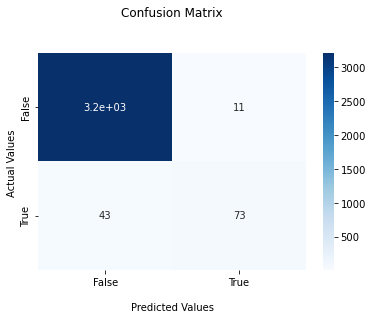

In [28]:
show_confusion_matrix(y_train, tree2.predict(X_train))

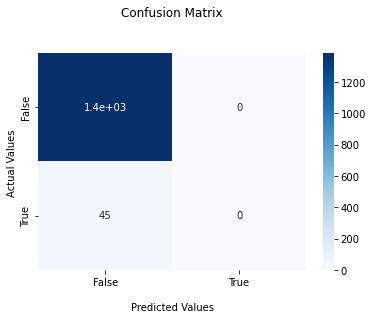

In [29]:
show_confusion_matrix(y_test, tree2.predict(X_test))

Widać, że w tym przypadku widać największą poprawę dla precision score. Także gini jest trochę lepsze niż przy pierwszym tuningu, jednak nie tak dobre jak dla modelu bazowego. Accuracy na zbiorze testowym także jest najlepsze ze wszystkich, jednak względem poprzedniego modelu jest to nieznaczna poprawa. 

Sprawdzimy jakie wyniki dla takiego wyboru parametrów da zastosowanie Random Search:

In [30]:
tree = DecisionTreeClassifier()
random = RandomizedSearchCV(estimator=tree, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 100)

random_result = random.fit(X_train, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.9652802019279827
Best parameters: {'splitter': 'best', 'min_samples_split': 9, 'min_samples_leaf': 0.5, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini', 'ccp_alpha': 0.05}


In [31]:
tree3 = DecisionTreeClassifier(ccp_alpha = 0.05,
                              criterion = 'gini',
                              max_depth = 5,
                              max_features ='log2',
                              min_samples_leaf = 0.5,
                              min_samples_split = 9,
                              splitter = 'best')
tree3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.05, max_depth=5, max_features='log2',
                       min_samples_leaf=0.5, min_samples_split=9)

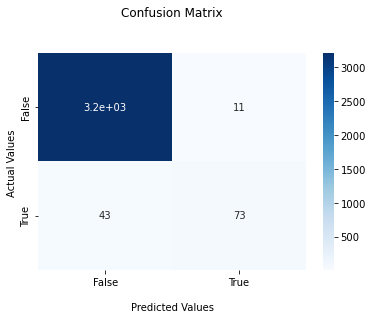

In [32]:
show_confusion_matrix(y_train, tree2.predict(X_train))

In [33]:
print_scores(tree3)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


W tym przypadku model nie jest przetrenowany, wuniki w zbiorze treniniowym i testowym są bardzo zbliżone. Wartość 0 w precision score bierze się z tego, że wartości *true positive* jest bardzo mało w porównaiu do *true negative*.

### Random Forest

In [34]:
forest_base = RandomForestClassifier()
forest_base.fit(X_train, y_train)
pred = forest_base.predict(X_test)

In [35]:
print_scores(forest_base)

ZBIÓR TRENINGOWY:
Model score: 0.9997006884166417
Precision score: 1.0
Gini score: 0.9956896551724138
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.05726256983240224
Precision score: 0.030913012221423435
Gini score: 0.4918368981815269


Podobnie jak w przypadku drzew decyzyjnych, acuuruacy score dla zbioru testowego jest bardzo wysoki, ale wydaje się, że model jest przetrenowany. Małe gini na zbiorze testowym to potwierdza.

Spróbujemy dobrać odpowiedznie hiperparametry:

In [36]:
max_depth=[3, 4, 5]
n_estimators = [80, 90, 100, 110, 120]
criterion=["gini","entrophy"]
min_samples_split = [2, 5, 10, 20, 50]
param_grid = dict(max_depth=max_depth, n_estimators = n_estimators, criterion=criterion, min_samples_split=min_samples_split)

In [37]:
forest = RandomForestClassifier()
grid = GridSearchCV(estimator=forest, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.9679730225647359
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100} 


In [38]:
forest = RandomForestClassifier(min_samples_split = 10,
                             criterion = 'gini',
                             max_depth = 5,
                             n_estimators = 110)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=110)

In [39]:
print_scores(forest)

ZBIÓR TRENINGOWY:
Model score: 0.9799461239149955
Precision score: 1.0
Gini score: 0.7112068965517242
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.03282122905027933
Precision score: 0.03146853146853147
Gini score: 0.5007209805335255


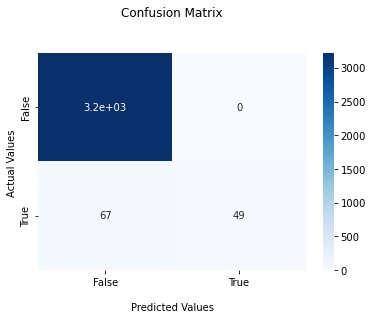

In [40]:
show_confusion_matrix(y_train, forest.predict(X_train))

Właściwie jedyne co się znacznie zmieniło to spadły wyniki dla zbioru testowego.

Sprawdźmy jakie hiperparametry wybierze random search:

In [41]:
forest = RandomForestClassifier()
random = RandomizedSearchCV(estimator=forest, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 100)

random_result = random.fit(X_train, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.9667758653097392
Best parameters: {'n_estimators': 90, 'min_samples_split': 10, 'max_depth': 3, 'criterion': 'gini'}


In [42]:
forest2 = RandomForestClassifier(min_samples_split = 5,
                                 criterion = 'gini',
                                 max_depth = 4,
                                 n_estimators = 100)
forest2.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_split=5)

In [43]:
print_scores(forest2)

ZBIÓR TRENINGOWY:
Model score: 0.9754564501646213
Precision score: 1.0
Gini score: 0.646551724137931
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.17108938547486033
Precision score: 0.036525974025974024
Gini score: 0.5720980533525595


W tym przypadku jest nieco niższe accuracy, jednak precision score jest równy 1, gini się jednak zmniejszyło

### Support Vector Machine (SVM)

In [44]:
svm_base = SVC()
svm_base.fit(X_train, y_train)
pred = svm_base.predict(X_test)

In [45]:
print_scores(svm_base)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


Model daje dobre wyniki accuracy, nie jest przetrenowany, jednak precision score jest zerowy. Sprawdźmy to na macierzy konfuzji.

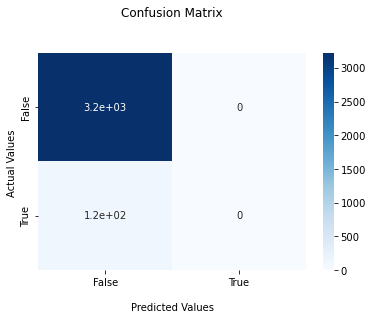

In [46]:
show_confusion_matrix(y_train, svm_base.predict(X_train))

Model ponownie nie przewiduje wartości *true*.

Spróbujmy teraz dobrać hiperparametry:

In [47]:
# Feature Scaling dla szybszego liczenia
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [48]:
C= [0.001, 0.01, 0.1,  1, 5]
kernel = ['linear', 'poly', 'sigmoid'] 
degree = [3,4,5]
gamma = ['scale', 'auto']
param_grid = dict(C=C, kernel=kernel, degree=degree, gamma=gamma)

In [49]:
# długo działa
svm_model = SVC()
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train_scaled, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.9682728712977632
Best parameters: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 


In [50]:
svm_1 = SVC(C = 0.01, 
            degree = 5, 
            gamma = 'scale',
            kernel = 'poly')
svm_1.fit(X_train, y_train)

SVC(C=0.01, degree=5, kernel='poly')

In [51]:
print_scores(svm_1)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


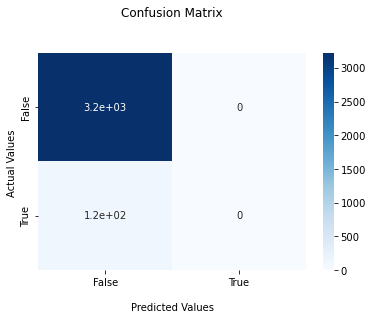

In [52]:
show_confusion_matrix(y_train, svm_1.predict(X_train))

Widać, że wynik na zbiorze testowym jest nieco niższy, jednak poskutkowało to niewielką poprawą na zbiorze testowym, co jest pożądaną zmianą. Jest to jednak niewielka zmiana. 

Sprawdźmy jakie wyniki da zastosowanie random search:

In [53]:
svm_model = SVC()
random = RandomizedSearchCV(estimator=svm_model, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 100)

random_result = random.fit(X_train_scaled, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.9679730225647359
Best parameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 0.1}


In [54]:
svm_2 = SVC(C = 0.1, 
            degree = 4, 
            gamma = 'scale',
            kernel = 'poly')
svm_2.fit(X_train, y_train)

SVC(C=0.1, degree=4, kernel='poly')

In [55]:
print_scores(svm_2)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


Wynik jest w tym przypakdu identyczny z tym poprzedni, wybranym przez grid search, jednak różnią się one dwoma hiperparamterami. Dla pierwszego *degree = 5*, *C = 0.01*, a w tym przypadku to *degree = 4*, *C = 0.1*

# Podsumowanie

* dodanie większej ilości parametrów do testowania nie zawsze jest opłacalne - liczy się dłużej, a wyniki niekoniecznie muszą być dużo lepsze. Nasz zbiór danych nie jest szczególnie duży, dlatego różnice w czasie nie były duże, ale już zauważalne. W przypadku większego zbioru mogłoby to stanowić problem i wtedy warto się zastanowić czy zależy nam na nieznacznym podniesieniu predykcyjności
* ranodm search jest niemal tak samo dobry jak grid serach, w jednym przypadku dał dokładnie ten sam wynik, w innych zblizony, lub nawet bardziej optymalny
